In [11]:
from rouge import Rouge
import pandas as pd
from pathlib import Path
import json


In [12]:
def getScore(candidate, reference, score_type='f', avg=True, raw=False):
    rouge = Rouge()
    scores = rouge.get_scores(candidate, reference, avg=avg)
    if raw:
        return scores
    elif avg:
        return {
            'rouge-1': scores['rouge-1'][score_type],
            'rouge-2': scores['rouge-2'][score_type],
            'rouge-l': scores['rouge-l'][score_type],
        }
    else:
        return [{
            'rouge-1': score['rouge-1'][score_type],
            'rouge-2': score['rouge-2'][score_type],
            'rouge-l': score['rouge-l'][score_type],
        } for score in scores]
    
def calRouge(df, ref, gen):
    generation = list(df[gen])
    reference = list(df[ref])    
    score = getScore(generation, reference, score_type='f', avg=False)
    return pd.DataFrame(score)

In [13]:
RAWDATAFILES = {
    "train": "training_complete.jsonl",
    "val": "validation_complete.jsonl",
    "test": "testing_with_paper_release.jsonl"
}

def load_ref(data_split='val'):
    filepath = str((Path().absolute()).parents[0])+"/dataset_MuP/"+RAWDATAFILES[data_split]
    with open(filepath, 'r') as json_file:
        json_list = list(json_file)
    dataset = []
    data_len = len(json_list)
    for i, json_str in enumerate(json_list):
        result = json.loads(json_str)
        dataset.append({
            "paper_id": result["paper_id"], 
            "ref_sum": result["summary"]
        })
    return pd.DataFrame(dataset)

def load_val_sum(model='bart-large', modelInput='summary-kg', evalInput='abstract-kg'):
    result_file = f"generated_summary/val/{model}/MODEL-{modelInput}_EVAL-{evalInput}.csv"
    gen = pd.read_csv(result_file, index_col=0)
    print(f"Loaded {len(gen)} results from {result_file}")
    ref = load_ref()
    if evalInput=='summary-kg':
        return pd.concat([gen.reset_index(drop=True), ref], axis=1)
    else:
        return pd.merge(gen, ref, on='paper_id', how='outer')

In [14]:
generated_sum = load_val_sum(model='bart-large', modelInput='abstract-text', evalInput='abstract-text')
print("Result lenght:",len(generated_sum))
generated_sum.head()

Loaded 1060 results from generated_summary/val/bart-large/MODEL-abstract-text_EVAL-abstract-text.csv
Result lenght: 3604


,paper_id,input,output_bestRouge1,ref_sum
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,Federated learning (FL) is a technique that tr...,This paper studies the problem of federated le...,This paper studies FL under local differential...
1,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,Federated learning (FL) is a technique that tr...,This paper studies the problem of federated le...,This paper studies a low communication algorit...
2,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,Federated learning (FL) is a technique that tr...,This paper studies the problem of federated le...,The paper proposed a differentially private tr...
3,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,Self-attention networks (SANs) have shown prom...,This paper proposes a self-attention network (...,This submission works on the neural machine tr...
4,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,Self-attention networks (SANs) have shown prom...,This paper proposes a self-attention network (...,This paper proposes a method to introduce **pr...


In [16]:
rouge_score = calRouge(generated_sum, 'ref_sum', 'output_bestRouge1')

In [17]:
rouge_score.describe()

,rouge-1,rouge-2,rouge-l
count,3604.000000,3604.000000,3604.000000
mean,0.316507,0.084862,0.287069
std,0.080087,0.067922,0.077933
min,0.076336,0.000000,0.076336
25%,0.262500,0.042857,0.235294
50%,0.307692,0.068966,0.277414
75%,0.358491,0.106094,0.325051
max,0.762887,0.692913,0.762887


In [6]:
models = [
    'bart-large', 
    'bart-large-cnn'
]
experiments = [
    ['abstract-kg', 'abstract-kg'],
    ['summary-kg', 'abstract-kg'],
    ['summary-kg', 'summary-kg'],
]
best_score = ['output_bestRouge1', 'output_bestRougeAvg']
exclude = [
    # 'bart-large-cnn_summary-kg_summary-kg',
]
exp_result = []
for model in models:
    for exp in experiments:
        modelInput = exp[0]
        evalInput = exp[1]
        if f"{model}_{modelInput}_{evalInput}" in exclude: continue
        generated_sum = load_val_sum(model, modelInput, evalInput)
        exp_result.append({
            'model': model,
            'modelInput': modelInput,
            'evalInput': evalInput,
        })
        for best in best_score:
            print(f"Calculating {best} | {modelInput} => {evalInput} | {model} Model")
            rouge_score = calRouge(generated_sum, 'ref_sum', best)
            exp_result[-1][best+'_all'] = rouge_score
            exp_result[-1][best+'_avg'] = rouge_score.mean()*100

Loaded 1060 results from generated_summary/val/bart-large/MODEL-abstract-kg_EVAL-abstract-kg.csv
Calculating output_bestRouge1 | abstract-kg => abstract-kg | bart-large Model
Calculating output_bestRougeAvg | abstract-kg => abstract-kg | bart-large Model
Loaded 1060 results from generated_summary/val/bart-large/MODEL-summary-kg_EVAL-abstract-kg.csv
Calculating output_bestRouge1 | summary-kg => abstract-kg | bart-large Model
Calculating output_bestRougeAvg | summary-kg => abstract-kg | bart-large Model
Loaded 3604 results from generated_summary/val/bart-large/MODEL-summary-kg_EVAL-summary-kg.csv
Calculating output_bestRouge1 | summary-kg => summary-kg | bart-large Model
Calculating output_bestRougeAvg | summary-kg => summary-kg | bart-large Model
Loaded 1060 results from generated_summary/val/bart-large-cnn/MODEL-abstract-kg_EVAL-abstract-kg.csv
Calculating output_bestRouge1 | abstract-kg => abstract-kg | bart-large-cnn Model
Calculating output_bestRougeAvg | abstract-kg => abstract-kg 

In [7]:
pd.DataFrame(exp_result)

,model,modelInput,evalInput,output_bestRouge1_all,output_bestRouge1_avg,output_bestRougeAvg_all,output_bestRougeAvg_avg
0,bart-large,abstract-kg,abstract-kg,rouge-1 rouge-2 rouge-l 0 0.381...,rouge-1 31.466940 rouge-2 7.781744 roug...,rouge-1 rouge-2 rouge-l 0 0.381...,rouge-1 31.466940 rouge-2 7.781744 roug...
1,bart-large,summary-kg,abstract-kg,rouge-1 rouge-2 rouge-l 0 0.385...,rouge-1 31.766326 rouge-2 7.516326 roug...,rouge-1 rouge-2 rouge-l 0 0.424...,rouge-1 31.612776 rouge-2 7.460802 roug...
2,bart-large,summary-kg,summary-kg,rouge-1 rouge-2 rouge-l 0 0.574...,rouge-1 50.903996 rouge-2 23.269560 roug...,rouge-1 rouge-2 rouge-l 0 0.560...,rouge-1 51.428717 rouge-2 23.726481 roug...
3,bart-large-cnn,abstract-kg,abstract-kg,rouge-1 rouge-2 rouge-l 0 0.508...,rouge-1 31.876530 rouge-2 7.748372 roug...,rouge-1 rouge-2 rouge-l 0 0.382...,rouge-1 31.584010 rouge-2 7.803705 roug...
4,bart-large-cnn,summary-kg,abstract-kg,rouge-1 rouge-2 rouge-l 0 0.397...,rouge-1 30.717318 rouge-2 7.356024 roug...,rouge-1 rouge-2 rouge-l 0 0.397...,rouge-1 30.717318 rouge-2 7.356024 roug...
5,bart-large-cnn,summary-kg,summary-kg,rouge-1 rouge-2 rouge-l 0 0.611...,rouge-1 51.585958 rouge-2 24.324294 roug...,rouge-1 rouge-2 rouge-l 0 0.611...,rouge-1 51.585958 rouge-2 24.324294 roug...


In [8]:
exp_result_avg = {}
for best in best_score:
    exp_result_avg[best] = [{
        'modelInput': result['modelInput'],
        'evalInput': result['evalInput'],
        'rouge-1': result[best+'_avg']['rouge-1'],
        'rouge-2': result[best+'_avg']['rouge-2'],
        'rouge-l': result[best+'_avg']['rouge-l'],
    } for result in exp_result]

In [9]:
pd.DataFrame(exp_result_avg['output_bestRouge1'])

,modelInput,evalInput,rouge-1,rouge-2,rouge-l
0,abstract-kg,abstract-kg,31.466940,7.781744,28.828969
1,summary-kg,abstract-kg,31.766326,7.516326,28.846003
2,summary-kg,summary-kg,50.903996,23.269560,46.283440
3,abstract-kg,abstract-kg,31.876530,7.748372,29.005506
4,summary-kg,abstract-kg,30.717318,7.356024,27.947179
5,summary-kg,summary-kg,51.585958,24.324294,47.160078


In [10]:
pd.DataFrame(exp_result_avg['output_bestRougeAvg'])

,modelInput,evalInput,rouge-1,rouge-2,rouge-l
0,abstract-kg,abstract-kg,31.466940,7.781744,28.828969
1,summary-kg,abstract-kg,31.612776,7.460802,28.902105
2,summary-kg,summary-kg,51.428717,23.726481,46.965711
3,abstract-kg,abstract-kg,31.584010,7.803705,28.848407
4,summary-kg,abstract-kg,30.717318,7.356024,27.947179
5,summary-kg,summary-kg,51.585958,24.324294,47.160078


In [11]:
df_exp_result_all = pd.DataFrame()
for best in best_score:
    for result in exp_result:
        df_ = result[best+'_all'].copy()
        df_['model'] = result['model']
        df_['modelInput_evalInput'] = f"{result['modelInput'][:3]}_{result['evalInput'][:3]}"
        df_['best'] = best[7:]
        df_exp_result_all = pd.concat([df_exp_result_all, df_])
df_exp_result_all.reset_index(drop=True, inplace=True)
df_exp_result_all

,rouge-1,rouge-2,rouge-l,model,modelInput_evalInput,best
0,0.381818,0.149254,0.309091,bart-large,abs_abs,bestRouge1
1,0.262295,0.050314,0.245902,bart-large,abs_abs,bestRouge1
2,0.306122,0.125000,0.306122,bart-large,abs_abs,bestRouge1
3,0.366667,0.133333,0.300000,bart-large,abs_abs,bestRouge1
4,0.302521,0.063694,0.285714,bart-large,abs_abs,bestRouge1
...,...,...,...,...,...,...
43243,0.539326,0.258065,0.516854,bart-large-cnn,sum_sum,bestRougeAvg
43244,0.571429,0.228070,0.439560,bart-large-cnn,sum_sum,bestRougeAvg
43245,0.596685,0.376471,0.574586,bart-large-cnn,sum_sum,bestRougeAvg
43246,0.418605,0.071429,0.387597,bart-large-cnn,sum_sum,bestRougeAvg


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

best = best_score[0]
df_plot = df_exp_result_all[df_exp_result_all['best']==best]

# Set the figure size
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True

# plt.figure(figsize=(5, 4)) #for a bigger image
sns.boxplot(hue="modelInput-evalInput", y="rouge-1", x="model", data=df_plot, palette="Set1").set(title=best[7:])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

ValueError: Could not interpret input 'modelInput-evalInput'

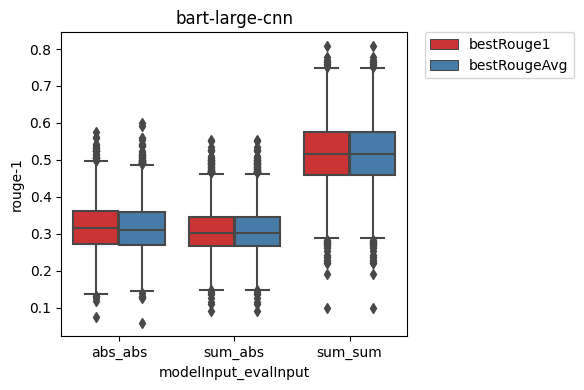

In [314]:
model = 'bart-large-cnn'
df_plot = df_exp_result_all[df_exp_result_all['model']==model]

# Set the figure size
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.autolayout"] = True

# plt.figure(figsize=(5, 4)) #for a bigger image
sns.boxplot(hue="best", y="rouge-1", x="modelInput_evalInput", data=df_plot, palette="Set1").set(title=model)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

# Visualizatdescriben loss

In [15]:
def load_record(model="bart-large", dataset="val", section="abstract", inputType="kg"):
    filepath = f"record_result/train_record/{model}_{section}_{inputType}.csv"
    losses = record.drop(['rouge-1', 'rouge-2', 'rouge-l', 'rouge-avg'], axis=1)
    rouge = record.drop(['loss'], axis=1).dropna()
    return pd.read_csv(filepath, index_col=0)
record = load_record(model="bart-large-cnn")

losses
rouge

,epoach,iteration,rouge-1,rouge-2,rouge-l,rouge-avg
499,0,500,0.304737,0.069223,0.279349,0.217770
999,0,1000,0.301557,0.068531,0.277701,0.215930
1499,0,1500,0.310504,0.071954,0.284780,0.222413
1999,0,2000,0.310608,0.073384,0.283306,0.222433
2499,1,2500,0.294006,0.067440,0.270119,0.210521
2999,1,3000,0.308780,0.073665,0.283670,0.222038
3499,1,3500,0.305427,0.071961,0.280219,0.219202
3999,1,4000,0.315053,0.075286,0.287216,0.225852
4499,1,4500,0.308912,0.072532,0.283718,0.221721
4999,2,5000,0.307450,0.072154,0.280165,0.219923


In [2]:
generated_sum = pd.read_csv("record_result/result_kg_abstract.csv", index_col=0)
generated_sum

,paper_id,gen_sum
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper proposes a new algorithm for federa...
1,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper proposes a new algorithm for federa...
2,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper proposes a new algorithm for federa...
3,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This paper proposes a method for self-attentio...
4,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This paper proposes a method for self-attentio...
...,...,...
3599,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,This paper proposes a method for learning repr...
3600,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,This paper proposes a method for learning repr...
3601,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,This paper proposes a unified formalism for gr...
3602,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,This paper proposes a unified formalism for gr...


In [3]:
generated_sum = generated_sum.drop_duplicates()
generated_sum

,paper_id,gen_sum
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper proposes a new algorithm for federa...
3,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This paper proposes a method for self-attentio...
6,SP:e3e728837f26acb9da283a42c219b6c3b3e131cb,This paper proposes a Bayesian Stackelberg Mar...
9,SP:97911e02bf06b34d022e7548beb5169a1d825903,This paper studies the problem of unsupervised...
12,SP:59f9de3ebe4a04d2fc8778d8e3415bf85efb7822,This paper proposes a zero-shot approach for a...
...,...,...
3589,SP:77b8bed08af8be8af0c65a72a6e22cfb02645d02,This paper proposes a hybrid method for variat...
3592,SP:64f2744e938bd62cd47c1066dc404a42134953da,This paper proposes a new method for causal in...
3595,SP:971d0d94adf5113ee1bef8df9ea7dbd508cf4cbc,This paper proposes a method for finding compa...
3598,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,This paper proposes a method for learning repr...


In [4]:
RAWDATAFILES = {
    "train": "training_complete.jsonl",
    "val": "validation_complete.jsonl",
    "test": "testing_with_paper_release.jsonl"
}

In [5]:
def load_data(filepath):
    with open(filepath, 'r') as json_file:
        json_list = list(json_file)
    dataset = []
    data_len = len(json_list)
    for i, json_str in enumerate(json_list):
        result = json.loads(json_str)
        dataset.append({
            "paper_id": result["paper_id"], 
            "ref_sum": result["summary"]
        })
    return pd.DataFrame(dataset)

In [6]:
main_path = str((Path().absolute()).parents[0])
filepath = main_path+"/dataset_MuP/"+RAWDATAFILES['val']
reference_sum = load_data(filepath)
reference_sum

,paper_id,ref_sum
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies FL under local differential...
1,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies a low communication algorit...
2,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,The paper proposed a differentially private tr...
3,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This submission works on the neural machine tr...
4,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This paper proposes a method to introduce **pr...
...,...,...
3599,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,This paper defines a set of learnable basis fu...
3600,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,A typical Wavelet Transform is built through t...
3601,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,This paper builds a new graph convolutional ne...
3602,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,The authors propose using non-Euclidean spaces...


In [7]:
summary_df = pd.merge(reference_sum, generated_sum, on='paper_id', how='inner')
summary_df

,paper_id,ref_sum,gen_sum
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies FL under local differential...,This paper proposes a new algorithm for federa...
1,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies a low communication algorit...,This paper proposes a new algorithm for federa...
2,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,The paper proposed a differentially private tr...,This paper proposes a new algorithm for federa...
3,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This submission works on the neural machine tr...,This paper proposes a method for self-attentio...
4,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This paper proposes a method to introduce **pr...,This paper proposes a method for self-attentio...
...,...,...,...
3599,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,This paper defines a set of learnable basis fu...,This paper proposes a method for learning repr...
3600,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,A typical Wavelet Transform is built through t...,This paper proposes a method for learning repr...
3601,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,This paper builds a new graph convolutional ne...,This paper proposes a unified formalism for gr...
3602,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,The authors propose using non-Euclidean spaces...,This paper proposes a unified formalism for gr...


In [8]:
# Define the reference and candidate texts
reference = list(summary_df['ref_sum'])
candidate = list(summary_df['gen_sum'])

In [9]:
def getScore(candidate, reference, score_type='f', avg=True, raw=False):
    rouge = Rouge()
    scores = rouge.get_scores(candidate, reference, avg=avg)
    if raw:
        return scores
    elif avg:
        return {
            'rouge-1': scores['rouge-1'][score_type],
            'rouge-2': scores['rouge-2'][score_type],
            'rouge-l': scores['rouge-l'][score_type],
        }
    else:
        return [{
            'rouge-1': score['rouge-1'][score_type],
            'rouge-2': score['rouge-2'][score_type],
            'rouge-l': score['rouge-l'][score_type],
        } for score in scores]

In [10]:
rouge_f = {
    'rouge-1': [],
    'rouge-2': [],
    'rouge-l': [],
}
scores = Rouge().get_scores(candidate[:], reference[:])
print(type(scores), len(scores))
for k in rouge_f.keys(): rouge_f[k]+=[score[k]['f'] for score in scores]
for k in rouge_f.keys(): rouge_f[k]=sum(rouge_f[k])/len(rouge_f[k])
rouge_f

<class 'list'> 3604


{'rouge-1': 0.3156685512055502,
 'rouge-2': 0.08091104371815014,
 'rouge-l': 0.28855005903195796}

In [11]:
getScore(candidate, reference, score_type='f', raw=True)

{'rouge-1': {'r': 0.28288095116248024,
  'p': 0.38480568718545277,
  'f': 0.3156685512055502},
 'rouge-2': {'r': 0.0754832289969406,
  'p': 0.09712896210009131,
  'f': 0.08091104371815014},
 'rouge-l': {'r': 0.2585875402641552,
  'p': 0.35186099061603626,
  'f': 0.28855005903195796}}

In [12]:
f1_score = getScore(candidate, reference, score_type='f', avg=False)
f1_score[0]

{'rouge-1': 0.439024385244233,
 'rouge-2': 0.14999999505000017,
 'rouge-l': 0.39024389743935495}

In [13]:
f1_df = pd.DataFrame(f1_score)
f1_df

,rouge-1,rouge-2,rouge-l
0,0.439024,0.150000,0.390244
1,0.340741,0.075676,0.340741
2,0.324324,0.116883,0.324324
3,0.420168,0.142012,0.369748
4,0.288136,0.074534,0.254237
...,...,...,...
3599,0.250000,0.054054,0.230769
3600,0.392157,0.076336,0.313725
3601,0.246753,0.076555,0.220779
3602,0.245902,0.024540,0.245902


In [14]:
f1_df.describe()

,rouge-1,rouge-2,rouge-l
count,3604.000000,3604.000000,3604.000000
mean,0.315669,0.080911,0.288550
std,0.068144,0.044611,0.064310
min,0.080000,0.000000,0.080000
25%,0.268041,0.049155,0.244444
50%,0.313043,0.074627,0.283582
75%,0.360360,0.105263,0.330097
max,0.621359,0.368000,0.610526


In [15]:
f1_df[f1_df['rouge-1']<0.1]

,rouge-1,rouge-2,rouge-l
300,0.097561,0.000000,0.085366
1501,0.080000,0.015873,0.080000
1776,0.088889,0.038835,0.088889


In [21]:
import sys

def getDataset(data_split):
    main_path = str((Path().absolute()).parents[0])    
    filepath = f"{main_path}/dataset_MuP/{RAWDATAFILES[data_split]}"
    with open(filepath, 'r') as json_file:
        json_list = list(json_file)
    dataset_list = []
    data_len = len(json_list)
    for i, json_str in enumerate(json_list):
        data = json.loads(json_str)
        dataset_list.append({
            "paper_id": data["paper_id"], 
            "input_seq": data["paper"]["abstractText"], 
            "target_seq": data["summary"]
        })   
        if i>100: break
    return pd.DataFrame(dataset_list)

In [22]:
getDataset("val")

,paper_id,input_seq,target_seq
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,Federated learning (FL) is a technique that tr...,This paper studies FL under local differential...
1,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,Federated learning (FL) is a technique that tr...,This paper studies a low communication algorit...
2,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,Federated learning (FL) is a technique that tr...,The paper proposed a differentially private tr...
3,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,Self-attention networks (SANs) have shown prom...,This submission works on the neural machine tr...
4,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,Self-attention networks (SANs) have shown prom...,This paper proposes a method to introduce **pr...
...,...,...,...
97,SP:d06bef9ee5e9bdda1571478b6a8a7a2d3ab42f1b,First-order stochastic methods for solving lar...,This paper proposed a Homotopy-Stochastic Grad...
98,SP:d06bef9ee5e9bdda1571478b6a8a7a2d3ab42f1b,First-order stochastic methods for solving lar...,1. It seems to me the proposed Homotopy-SGD is...
99,SP:195d090d9df0bda33103edcbbaf300e43f4562be,Estimating the 3D shape of real-world objects ...,This paper proposes a way of reconstructing a ...
100,SP:195d090d9df0bda33103edcbbaf300e43f4562be,Estimating the 3D shape of real-world objects ...,This paper introduces a meta-learning approach...


In [23]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {(info.total/1e9):.2f} GB')
print(f'free     : {(info.free/1e9):.2f} GB')
print(f'used     : {(info.used/1e9):.2f} GB')

total    : 51.53 GB
free     : 29.52 GB
used     : 22.00 GB


In [24]:
info.used/1e9

22.002466816

In [58]:
output_file = "result_kg_abstract.csv"
generated_sum = pd.read_csv(f"record_result/{output_file}", index_col=0)
generated_sum = generated_sum.drop_duplicates()
main_path = str((Path().absolute()).parents[0])
filepath = main_path+"/dataset_MuP/"+RAWDATAFILES['val']
reference_sum = load_data(filepath)

summary_df = pd.merge(reference_sum, generated_sum, on='paper_id', how='inner')

(generated_sum)

,paper_id,gen_sum
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper proposes a new algorithm for federa...
3,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This paper proposes a method for self-attentio...
6,SP:e3e728837f26acb9da283a42c219b6c3b3e131cb,This paper proposes a Bayesian Stackelberg Mar...
9,SP:97911e02bf06b34d022e7548beb5169a1d825903,This paper studies the problem of unsupervised...
12,SP:59f9de3ebe4a04d2fc8778d8e3415bf85efb7822,This paper proposes a zero-shot approach for a...
...,...,...
3589,SP:77b8bed08af8be8af0c65a72a6e22cfb02645d02,This paper proposes a hybrid method for variat...
3592,SP:64f2744e938bd62cd47c1066dc404a42134953da,This paper proposes a new method for causal in...
3595,SP:971d0d94adf5113ee1bef8df9ea7dbd508cf4cbc,This paper proposes a method for finding compa...
3598,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,This paper proposes a method for learning repr...


In [59]:
reference_sum

,paper_id,ref_sum
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies FL under local differential...
1,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies a low communication algorit...
2,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,The paper proposed a differentially private tr...
3,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This submission works on the neural machine tr...
4,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This paper proposes a method to introduce **pr...
...,...,...
3599,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,This paper defines a set of learnable basis fu...
3600,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,A typical Wavelet Transform is built through t...
3601,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,This paper builds a new graph convolutional ne...
3602,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,The authors propose using non-Euclidean spaces...


In [27]:
summary_df

,paper_id,ref_sum,gen_sum
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies FL under local differential...,This paper proposes a new algorithm for federa...
1,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies a low communication algorit...,This paper proposes a new algorithm for federa...
2,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,The paper proposed a differentially private tr...,This paper proposes a new algorithm for federa...
3,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This submission works on the neural machine tr...,This paper proposes a method for self-attentio...
4,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This paper proposes a method to introduce **pr...,This paper proposes a method for self-attentio...
...,...,...,...
3599,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,This paper defines a set of learnable basis fu...,This paper proposes a method for learning repr...
3600,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,A typical Wavelet Transform is built through t...,This paper proposes a method for learning repr...
3601,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,This paper builds a new graph convolutional ne...,This paper proposes a unified formalism for gr...
3602,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,The authors propose using non-Euclidean spaces...,This paper proposes a unified formalism for gr...


In [41]:
output_file = "result_kg_summary.csv"
generated_sum = pd.read_csv(f"record_result/{output_file}", index_col=0)
generated_sum = generated_sum.drop_duplicates()
main_path = str((Path().absolute()).parents[0])
filepath = main_path+"/dataset_MuP/"+RAWDATAFILES['val']
reference_sum = load_data(filepath)

summary_df = pd.merge(reference_sum, generated_sum, on='paper_id', how='inner')

(generated_sum)

,paper_id,input,output
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,local differential privacy constraints FEATURE...,This paper studies the problem of privacy-pres...
1,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,low communication algorithm USED-FOR multivari...,This paper proposes a low communication algori...
2,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,differentially private training algorithm USED...,This paper proposes a differentially private t...
3,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,language statistics CONJUNCTION prior knowledg...,This paper studies the neural machine translat...
4,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,Transformer - based sentence encoders USED-FOR...,This paper proposes a method to incorporate pr...
...,...,...,...
3599,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,joint learning algorithm USED-FOR them. common...,This paper proposes a common learning approach...
3600,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,group action FEATURE-OF mother wavelet. dilati...,"This paper proposes Wavelet Transform, which i..."
3601,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,hyperbolic representations of the graph nodes ...,This paper proposes a graph convolutional netw...
3602,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,non - Euclidean spaces USED-FOR GCNs. embeddin...,This paper studies GCNs in non-Euclidean space...


In [42]:
generated_sum.reset_index(drop=True, inplace=True)

In [43]:
summary_df = pd.concat([reference_sum, generated_sum], axis=1)
summary_df

,paper_id,ref_sum,paper_id,input,output
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies FL under local differential...,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,local differential privacy constraints FEATURE...,This paper studies the problem of privacy-pres...
1,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies a low communication algorit...,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,low communication algorithm USED-FOR multivari...,This paper proposes a low communication algori...
2,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,The paper proposed a differentially private tr...,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,differentially private training algorithm USED...,This paper proposes a differentially private t...
3,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This submission works on the neural machine tr...,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,language statistics CONJUNCTION prior knowledg...,This paper studies the neural machine translat...
4,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This paper proposes a method to introduce **pr...,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,Transformer - based sentence encoders USED-FOR...,This paper proposes a method to incorporate pr...
...,...,...,...,...,...
3599,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,This paper defines a set of learnable basis fu...,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,joint learning algorithm USED-FOR them. common...,This paper proposes a common learning approach...
3600,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,A typical Wavelet Transform is built through t...,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,group action FEATURE-OF mother wavelet. dilati...,"This paper proposes Wavelet Transform, which i..."
3601,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,This paper builds a new graph convolutional ne...,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,hyperbolic representations of the graph nodes ...,This paper proposes a graph convolutional netw...
3602,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,The authors propose using non-Euclidean spaces...,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,non - Euclidean spaces USED-FOR GCNs. embeddin...,This paper studies GCNs in non-Euclidean space...


In [50]:
reference = list(summary_df['ref_sum'])
candidate = list(summary_df['output'])

score = getScore(candidate, reference, score_type='f', avg=False)
score_df = pd.DataFrame(score)
score_df.describe()

,rouge-1,rouge-2,rouge-l
count,3604.000000,3604.000000,3604.000000
mean,0.524334,0.255257,0.479214
std,0.087356,0.087325,0.089532
min,0.078947,0.000000,0.078947
25%,0.465383,0.193548,0.418182
50%,0.524041,0.248216,0.474150
75%,0.583485,0.311927,0.538462
max,0.831683,0.645161,0.831683


In [51]:
reference_sum

,paper_id,ref_sum
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies FL under local differential...
1,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies a low communication algorit...
2,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,The paper proposed a differentially private tr...
3,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This submission works on the neural machine tr...
4,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This paper proposes a method to introduce **pr...
...,...,...
3599,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,This paper defines a set of learnable basis fu...
3600,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,A typical Wavelet Transform is built through t...
3601,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,This paper builds a new graph convolutional ne...
3602,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,The authors propose using non-Euclidean spaces...


In [52]:
summary_df

,paper_id,ref_sum,paper_id,input,output
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies FL under local differential...,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,local differential privacy constraints FEATURE...,This paper studies the problem of privacy-pres...
1,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies a low communication algorit...,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,low communication algorithm USED-FOR multivari...,This paper proposes a low communication algori...
2,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,The paper proposed a differentially private tr...,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,differentially private training algorithm USED...,This paper proposes a differentially private t...
3,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This submission works on the neural machine tr...,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,language statistics CONJUNCTION prior knowledg...,This paper studies the neural machine translat...
4,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This paper proposes a method to introduce **pr...,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,Transformer - based sentence encoders USED-FOR...,This paper proposes a method to incorporate pr...
...,...,...,...,...,...
3599,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,This paper defines a set of learnable basis fu...,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,joint learning algorithm USED-FOR them. common...,This paper proposes a common learning approach...
3600,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,A typical Wavelet Transform is built through t...,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,group action FEATURE-OF mother wavelet. dilati...,"This paper proposes Wavelet Transform, which i..."
3601,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,This paper builds a new graph convolutional ne...,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,hyperbolic representations of the graph nodes ...,This paper proposes a graph convolutional netw...
3602,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,The authors propose using non-Euclidean spaces...,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,non - Euclidean spaces USED-FOR GCNs. embeddin...,This paper studies GCNs in non-Euclidean space...


In [66]:
def calRouge(inputType='kg', section='abstract'):
    generated_sum = pd.read_csv(f"record_result/result_{inputType}_{section}.csv", index_col=0)
    if section=='summary':
        generated_sum = generated_sum.drop_duplicates()
    main_path = str((Path().absolute()).parents[0])
    filepath = main_path+"/dataset_MuP/"+RAWDATAFILES['val']
    reference_sum = load_data(filepath)
    
    summary_df = pd.merge(reference_sum, generated_sum, on='paper_id', how='inner')
    
    reference = list(summary_df['ref_sum'])
    try:
        candidate = list(summary_df['gen_sum'])
    except:
        candidate = list(summary_df['output'])
    
    score = getScore(candidate, reference, score_type='f', avg=False)
    score_df = pd.DataFrame(score)
    return summary_df, score_df

In [63]:
abs_text_data, abs_text_score = calRouge(inputType='text', section='abstract')
abs_text_score.describe()

,rouge-1,rouge-2,rouge-l
count,13104.000000,13104.000000,13104.000000
mean,0.319775,0.087505,0.289468
std,0.078043,0.066710,0.076373
min,0.044118,0.000000,0.044118
25%,0.267717,0.046512,0.238532
50%,0.310811,0.072072,0.280000
75%,0.361905,0.109091,0.327586
max,0.834951,0.757576,0.800000


In [64]:
abs_kg_data, abs_kg_score = calRouge(inputType='kg', section='abstract')
abs_kg_score.describe()

,rouge-1,rouge-2,rouge-l
count,13104.000000,13104.000000,13104.000000
mean,0.316231,0.081455,0.289072
std,0.068300,0.044617,0.064410
min,0.080000,0.000000,0.080000
25%,0.268657,0.050000,0.244604
50%,0.313725,0.075188,0.283871
75%,0.361702,0.105882,0.330275
max,0.621359,0.368000,0.610526


In [67]:
sum_kg_data, sum_kg_score = calRouge(inputType='kg', section='summary')
sum_kg_score.describe()

,rouge-1,rouge-2,rouge-l
count,13104.000000,13104.000000,13104.000000
mean,0.353925,0.115290,0.322875
std,0.126439,0.102582,0.118290
min,0.065217,0.000000,0.065217
25%,0.263158,0.043860,0.238095
50%,0.317757,0.075269,0.290076
75%,0.428571,0.161319,0.388227
max,0.831683,0.645161,0.831683


In [73]:
abs_text_score

,rouge-1,rouge-2,rouge-l
0,0.657534,0.456522,0.657534
1,0.657534,0.456522,0.657534
2,0.657534,0.456522,0.657534
3,0.379747,0.114833,0.329114
4,0.379747,0.114833,0.329114
...,...,...,...
13099,0.195122,0.013423,0.195122
13100,0.195122,0.013423,0.195122
13101,0.283019,0.050420,0.207547
13102,0.283019,0.050420,0.207547


In [68]:
df_boxplot = pd.melt(abs_text_score, value_vars=['rouge-1','rouge-2','rouge-l'], var_name="score")
df_boxplot["input"] = "abs_text"

In [69]:
df_boxplot_ = pd.melt(abs_kg_score, value_vars=['rouge-1','rouge-2','rouge-l'], var_name="score")
df_boxplot_["input"] = "abs_kg"

In [70]:
df_boxplot = pd.concat([df_boxplot, df_boxplot_])

In [71]:
df_boxplot_ = pd.melt(sum_kg_score, value_vars=['rouge-1','rouge-2','rouge-l'], var_name="score")
df_boxplot_["input"] = "sum_kg"
df_boxplot = pd.concat([df_boxplot, df_boxplot_])

In [72]:
df_boxplot

,score,value,input
0,rouge-1,0.657534,abs_text
1,rouge-1,0.657534,abs_text
2,rouge-1,0.657534,abs_text
3,rouge-1,0.379747,abs_text
4,rouge-1,0.379747,abs_text
...,...,...,...
39307,rouge-l,0.357143,sum_kg
39308,rouge-l,0.259259,sum_kg
39309,rouge-l,0.147541,sum_kg
39310,rouge-l,0.252632,sum_kg


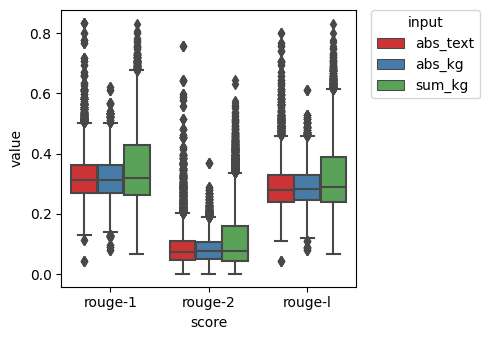

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [5, 3.50]
plt.rcParams["figure.autolayout"] = True

# plt.figure(figsize=(5, 4)) #for a bigger image
sns.boxplot(x="score", y="value", hue="input", data=df_boxplot, palette="Set1")
plt.legend(bbox_to_anchor=(1.05, 1), title="input", loc='upper left', borderaxespad=0)


In [ ]:
kgSum_sum

In [ ]:
abs_kg_sum

In [ ]:
abs_fulltext_sum

In [ ]:
all_result = pd.copy

In [ ]:
def print_example(summary_df, i):
    print("Reference:")
    print(summary_df.iloc[i]['ref_sum'])
    print("Generation:")
    print(summary_df.iloc[i]['gen_sum'])

In [ ]:
print_example(abs_kg_sum, 1635)


In [ ]:
print_example(abs_fulltext_sum, 1635)


In [ ]:
main_path = str((Path().absolute()).parents[0])
filepath = main_path+"/dataset_MuP/"+RAWDATAFILES['val']
reference_sum = load_data(filepath)
reference_sum

In [ ]:
reference_sum[reference_sum["paper_id"]=="SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96"]["ref_sum"][0]

# Prepare PL-Marker

In [ ]:
def load_val_sum(model='bart-large', modelInput='summary-kg', evalInput='abstract-kg'):
    result_file = f"generated_summary/val/{model}/MODEL-{modelInput}_EVAL-{evalInput}.csv"
    gen = pd.read_csv(result_file, index_col=0)
    print(f"Loaded {len(gen)} results from {result_file}")
    ref = load_ref()
    if evalInput=='summary-kg':
        return pd.concat([gen.reset_index(drop=True), ref], axis=1)
    else:
        return pd.merge(gen, ref, on='paper_id', how='outer')

In [321]:
model='bart-large'
modelInput='summary-kg' 
evalInput='summary-kg'
main_path = str((Path().absolute()).parents[0])
result_file = f"/FT_PT_model/generated_summary/val/{model}/MODEL-{modelInput}_EVAL-{evalInput}.csv"

In [326]:
gen = pd.read_csv(main_path+result_file, index_col=0)
doc_col = "paper_id"
sentence_col = "output_bestRouge1"
doc_key = list(gen[doc_col])
sentences = list(gen[sentence_col])


dataset= [{
    "doc_key": doc_key[i],
    "sentences": sentences[i],
} for i in range(len(doc_key))]

dataset[0]

{'doc_key': 'SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96',
 'sentences': 'This paper studies the problem of privacy-preserving FL algorithms with local differential privacy constraints. The authors propose a gradient-based learning algorithm sqSGD with randomized rotation to reduce the quantization error. The communication efficiency and highdimensional compatibility of the proposed gradient subsampling strategy are studied. The experimental results show that the proposed base algorithm achieves better communication costs.'}

In [327]:
result_file

'/FT_PT_model/generated_summary/val/bart-large/MODEL-summary-kg_EVAL-summary-kg.csv'